In [1]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
import pandas as pd
import cv2
import json
import seaborn as sns
import os

from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import r2_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.linear_model import ElasticNet
from xgboost.sklearn import XGBRegressor
import lightgbm as ltb

from google.colab import drive
drive.mount('/content/drive', force_remount=True)
os.chdir("/content/drive/Shared drives/Tecnicas de aprendizaje estadistico/Trabajo 4")

Mounted at /content/drive


In [2]:
data = pd.read_csv('datasets/registros_autos_entrenamiento.csv')

In [3]:
df = data.copy()
df.head()

,Fecha,Unidades
0,1/1/2012,0
1,2/1/2012,188
2,3/1/2012,482
3,4/1/2012,927
4,5/1/2012,1159


### Convertir fecha que esta en formato object a fecha en formato datetime

In [4]:
df["Fecha"] = pd.to_datetime(df["Fecha"], format="%d/%m/%Y")

###  Variables del tiempo

In [5]:
df = df.set_index(df["Fecha"])
df.index.name = None
df.drop(columns=["Fecha"],inplace=True)

df['Dia'] = df.index.day
df['Mes'] = df.index.month
df['Anio'] = df.index.year
df['DiaSemana'] = df.index.weekday
df.sample(5)

,Unidades,Dia,Mes,Anio,DiaSemana
2013-09-09,878,9,9,2013,0
2014-10-06,929,6,10,2014,0
2017-10-08,7,8,10,2017,6
2015-04-19,11,19,4,2015,6
2013-12-05,1313,5,12,2013,3


### Conjunto de datos del 2018

In [6]:
index_new = pd.date_range(start="2018-01-01",end="2018-06-30")
df_validacion = pd.DataFrame(index_new, columns=["Fecha"])
df_validacion["Fecha"] = pd.to_datetime(df_validacion["Fecha"], format="%d/%m/%Y")

df_validacion = df_validacion.set_index(df_validacion["Fecha"])
df_validacion.index.name = None
df_validacion.drop(columns=["Fecha"],inplace=True)

df_validacion['Dia'] = df_validacion.index.day
df_validacion['Mes'] = df_validacion.index.month
df_validacion['Anio'] = df_validacion.index.year
df_validacion['DiaSemana'] = df_validacion.index.weekday
df_validacion.head(15)

,Dia,Mes,Anio,DiaSemana
2018-01-01,1,1,2018,0
2018-01-02,2,1,2018,1
2018-01-03,3,1,2018,2
2018-01-04,4,1,2018,3
2018-01-05,5,1,2018,4
2018-01-06,6,1,2018,5
2018-01-07,7,1,2018,6
2018-01-08,8,1,2018,0
2018-01-09,9,1,2018,1
2018-01-10,10,1,2018,2


### Función para generar un conjunto de datos de testeo

In [7]:
def generate_test(initial_time_test, final_time_test):
  """
  Esta función recibe dos fechas en el formato YYYY-MM-DD. La primera fecha es la fecha inicial del dataset de testeo 
  y la segunda fecha es la fecha final del dataset de testeo. Devuelve un conjunto de datos para entrenar y para testear.
  """

  X = df.drop("Unidades", axis=1)
  y = df[["Unidades"]]

  # Los datos para entrenamiento van desde el 2012-01-01 hasta el 2016-12-31
  X_train = X.loc["2012-01-01":"2016-12-31"]
  y_train = y.loc["2012-01-01":"2016-12-31"]

  X_test = X.loc[initial_time_test:final_time_test]
  y_test = y.loc[initial_time_test:final_time_test]

  return {"X_train":X_train, "y_train":y_train, "X_test":X_test, "y_test": y_test}
generate_test("2017-01-01", "2017-12-01")["X_train"]

,Dia,Mes,Anio,DiaSemana
2012-01-01,1,1,2012,6
2012-01-02,2,1,2012,0
2012-01-03,3,1,2012,1
2012-01-04,4,1,2012,2
2012-01-05,5,1,2012,3
...,...,...,...,...
2016-12-27,27,12,2016,1
2016-12-28,28,12,2016,2
2016-12-29,29,12,2016,3
2016-12-30,30,12,2016,4


### Prediccion para el 2017

El modelo Regresion lineal arroja un R2 de: 0.257
El modelo Random Forest arroja un R2 de: 0.95
El modelo KNN arroja un R2 de: 0.768
El modelo Scaled GBM arroja un R2 de: 0.822


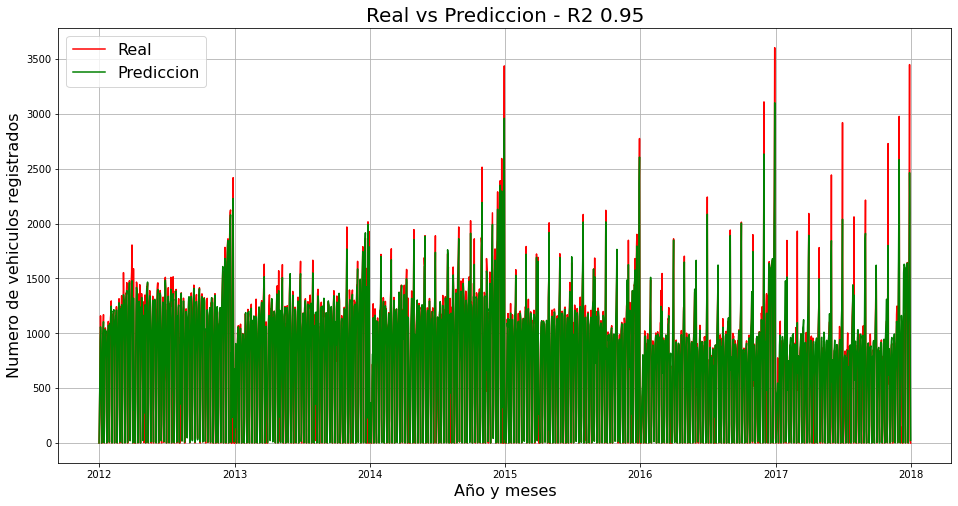

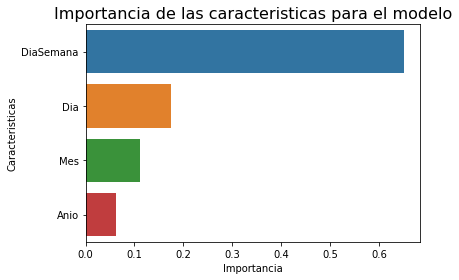

In [8]:
import warnings
warnings.filterwarnings('ignore')

def train_time_series():

  # Los datos para validacion van desde el 2017-06-30 hasta el 2017-12-01
  train_test_dataset = generate_test("2017-01-01", "2017-12-31")
  models = []
  models.append(('Regresion lineal', LinearRegression()))
  models.append(('Random Forest', RandomForestRegressor()))
  models.append(('KNN', KNeighborsRegressor()))
  models.append(('Scaled GBM', GradientBoostingRegressor()))
  results = []
  names = []

  best_R2 = 0
  best_model = {}

  for name, model in models:
    model.fit(train_test_dataset["X_train"], train_test_dataset["y_train"])
    predictions = model.predict(train_test_dataset["X_test"])
    R2 = np.round(r2_score(train_test_dataset["y_test"], predictions), 3)
    if R2 > best_R2:
      best_model = {"Model": model, "Predictions":predictions, "R2":R2}
      best_R2 = R2
    msg = f"El modelo {name} arroja un R2 de: {R2}" 
    print(msg)

  predictions=np.round(best_model["Model"].predict(train_test_dataset["X_test"]),0)

  # Plot real vs prediccion con R2
  fig = plt.figure(figsize=(16,8))
  plt.title(f'Real vs Prediccion - R2 {best_model["R2"]}', fontsize=20)
  plt.plot(train_test_dataset["y_test"], color='red')
  plt.plot(pd.Series(np.reshape(best_model["Predictions"], (1,-1))[0], index=train_test_dataset["y_test"].index), color='green')
  plt.xlabel('Año y meses', fontsize=16)
  plt.ylabel('Numero de vehiculos registrados', fontsize=16)
  plt.legend(labels=['Real', 'Prediccion'], fontsize=16)
  plt.grid()
  plt.show()

  # Dataframe de importancia de las caracteristicas
  df_importances = pd.DataFrame({
      'Caracteristicas': train_test_dataset["X_train"].columns,
      'Importancia': best_model["Model"].feature_importances_
  }).sort_values(by='Importancia', ascending=False)
    
  # Plot de la importancia de las caracteristicas del modelo
  plt.title('Importancia de las caracteristicas para el modelo', fontsize=16)
  sns.barplot(x=df_importances.Importancia, y=df_importances.Caracteristicas, orient='h')
  plt.show()
  return predictions


predicciones_archivo_uno = train_time_series()

## IMPORTANTE
## Comentar las siguientes lineas si se desea correr nuevamente el codigo
archivo_uno = pd.DataFrame({"Fecha":df.index, "Unidades":predicciones_archivo_uno})
archivo_uno.to_csv('datasets/archivo_uno.csv', index=False)

### Predicción para el 2018

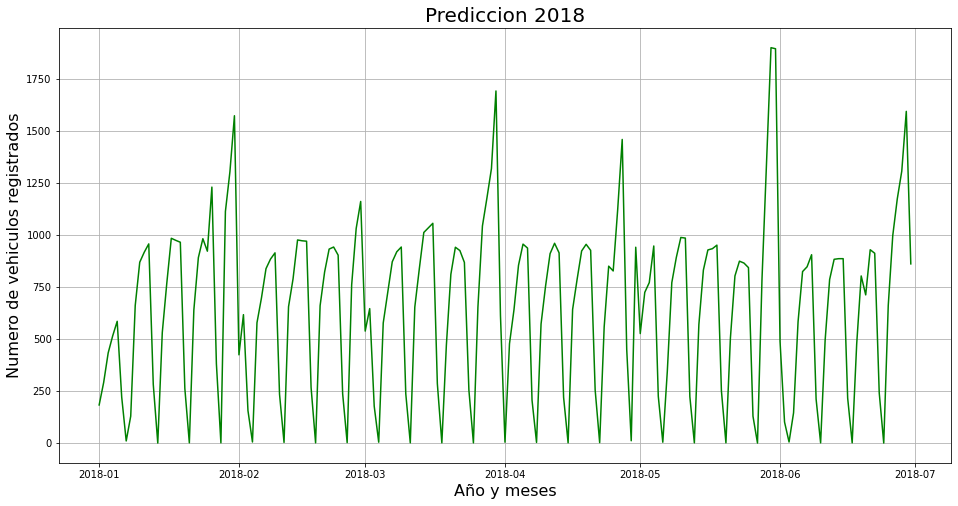

In [9]:
import warnings
warnings.filterwarnings('ignore')

def validate_2018():

  train_test_dataset = generate_test("2017-01-01", "2017-12-01")
  
  X_train = train_test_dataset["X_train"]
  y_train = train_test_dataset["y_train"]
  X_test = df_validacion
  
  model = RandomForestRegressor()
  model.fit(X_train, y_train)
  predictions = np.round(model.predict(X_test),0)

  # Plot real vs prediccion con R2
  fig = plt.figure(figsize=(16,8))
  plt.title(f'Prediccion 2018', fontsize=20)
  plt.plot(pd.Series(np.reshape(predictions, (1,-1))[0], index=X_test.index), color='green')
  plt.xlabel('Año y meses', fontsize=16)
  plt.ylabel('Numero de vehiculos registrados', fontsize=16)
  plt.grid()
  plt.show()
  return predictions

predicciones_archivo_dos = validate_2018()
archivo_dos = pd.DataFrame({"Fecha":df_validacion.index, "Unidades":predicciones_archivo_dos})
archivo_dos.to_csv('datasets/archivo_dos.csv', index=False)